In [1]:
%load_ext autoreload
%autoreload 2

import librosa
import librosa.display
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import IPython.display

In [2]:
audio, _ = librosa.load("./data/sentence.wav", sr=8000)

In [3]:
audio, _ = librosa.load("./data/ILoveKanye.mp3", sr=8000)

/Users/vaclav/prog/venv2/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


In [3]:
def play(audio, sr=8000):
    IPython.display.display(IPython.display.Audio(audio, rate=sr))

def specplot(audio, n_fft=512, sr=8000):
    S = librosa.stft(audio, n_fft=n_fft)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    librosa.display.specshow(S_db, y_axis="linear", sr=sr, n_fft=n_fft)

In [4]:
audio2 = scipy.signal.lfilter(np.array([1.0, -0.9]), 1, audio)

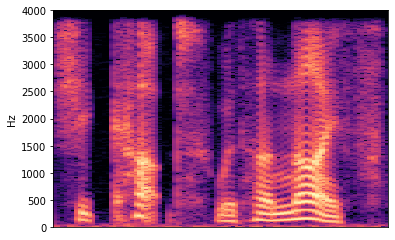

In [5]:
specplot(audio)

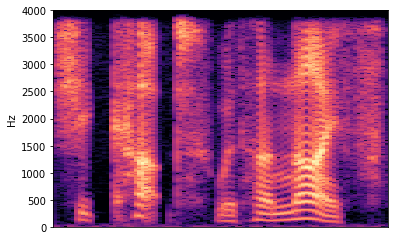

In [6]:
specplot(audio2)

In [7]:
play(audio)

In [8]:
play(audio2)

In [20]:
from sine_wave_speech.lpc import fit_lpc, lpc_coefficients_to_frequencies

lpc_coefficients, gain, residual = fit_lpc(audio, p=8)

frequencies, magnitudes = lpc_coefficients_to_frequencies(lpc_coefficients, gain)
# Convert to Hz
frequencies = frequencies * 8000 / (2 * np.pi)

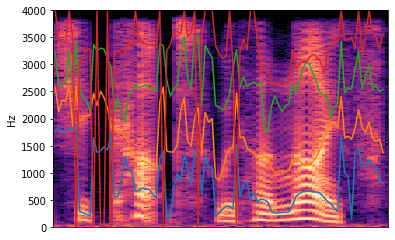

In [21]:
plt.plot(frequencies[:100])
specplot(audio, n_fft=512)

In [46]:
def synthtrax(F, M, SR, SUBF=128, DUR=0):
    cols, rows = F.shape

    opsamps = round(DUR * SR)
    if DUR == 0:
        opsamps = 1 + (cols - 1) * SUBF

    X = np.zeros(opsamps)

    for row in range(rows):
        mm = M[:, row]
        ff = F[:, row]

        mm = np.nan_to_num(mm)
        ff = np.nan_to_num(ff)
        # assert np.sum(mm == 0) == 0

        nzcols = len(mm)

        def resample(x, factor):
            output_size = (len(mm) - 1) * factor + 1
            return np.interp(
                np.arange(output_size),
                np.arange(len(x)) * factor,
                x
            )

        ff = resample(ff, factor=SUBF)
        mm = resample(mm, factor=SUBF)
        
        pp = np.cumsum(2*np.pi*ff/SR)

        xx = mm * np.cos(pp)
#         xx = mm * scipy.signal.sawtooth(pp)
#         xx = mm * scipy.signal.square(pp)

        X += xx
#         break
    
    return X


X = synthtrax(frequencies, magnitudes, SUBF=256, SR=8000)

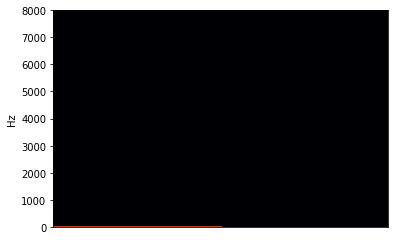

In [47]:
specplot(X, sr=16000)
plt.plot(frequencies[:100])

In [48]:
play(X, sr=8000)

/Users/vaclav/prog/venv2/lib/python3.9/site-packages/IPython/lib/display.py:187: RuntimeWarning: invalid value encountered in true_divide
  scaled = data / normalization_factor * 32767


In [49]:
import sine_wave_speech.synthesis

In [50]:
play(sine_wave_speech.synthesis.synthesize(frequencies, magnitudes, sr=8000), sr=8000)